# GuardianCGM: Model Deployment & Real-Time Inference Pipeline

**Author:** Alex Domingues Batista  
Academic leader, researcher, and educator with expertise in Chemistry, Sustainability, and Data Science. Passionate about MedTech innovation and regulatory excellence.

---

**Objective:** Deploy a validated forecasting model and demonstrate a real-time inference pipeline for hypoglycemia risk prediction. This notebook is designed for MedTech and digital health applications in Germany and Europe, focusing on clinical safety, explainability, and integration readiness.

## Step 1: Load the Trained Model

Load the validated Random Forest model from disk. All predictions are based on a model that has passed rigorous clinical and statistical validation.

In [1]:
# Import required libraries for model deployment
import joblib

In [2]:
# Load the trained model (updated path and filename)
model = joblib.load('models/glucose_rf_v1.pkl')

## Step 2: Real-Time Inference Pipeline

This section demonstrates a complete inference pipeline that simulates real-time CGM data processing and prediction. The pipeline includes:
- Data loading and feature extraction
- Glucose prediction with uncertainty quantification
- Clinical zone visualization (hypoglycemia, target range, hyperglycemia)
- Explainability through SHAP analysis

**Clinical Zones:**
- **Hypoglycemia:** < 70 mg/dL (requires immediate attention)
- **Target Range:** 70-180 mg/dL (optimal glucose control)
- **Hyperglycemia:** > 180 mg/dL (may require intervention)

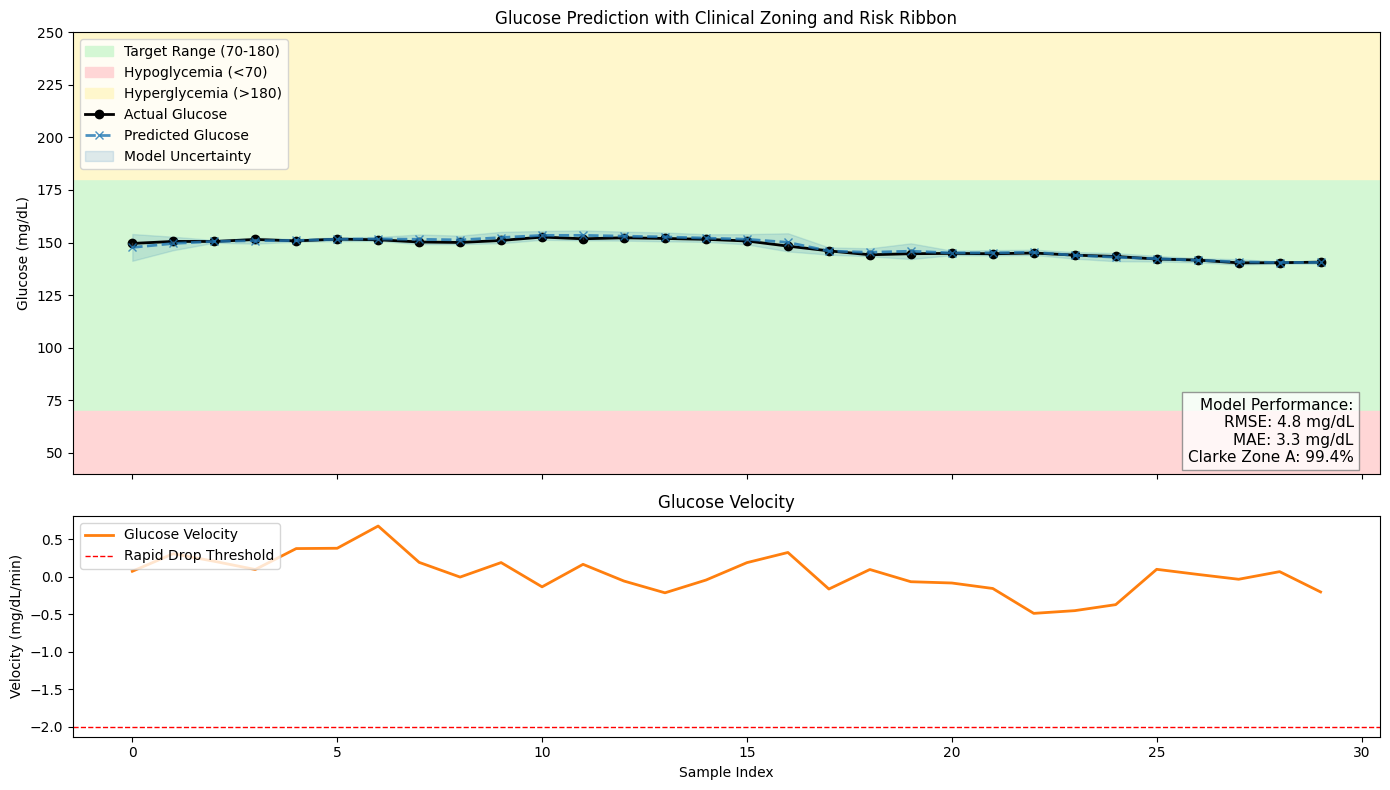

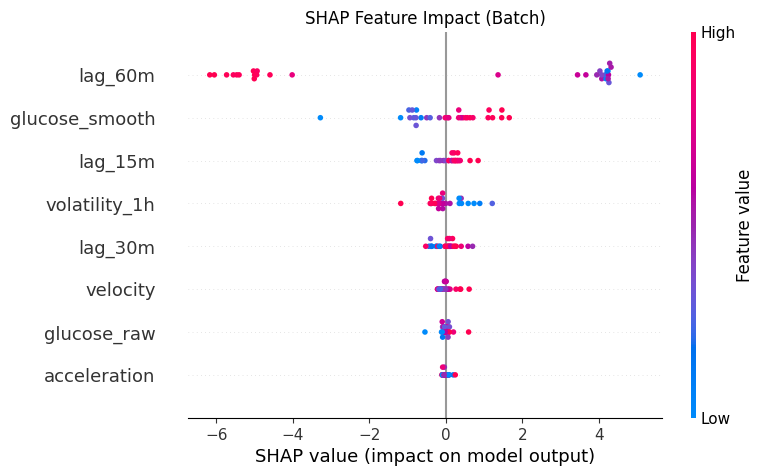

In [4]:
# Inference: Professional Medical R&D Dashboard (Safety-First)
import pandas as pd
import matplotlib.pyplot as plt
import shap
import numpy as np

biomarkers_df = pd.read_csv('data/processed_biomarkers.csv')
# Use all features that model was trained on (excluding timestamp and target)
feature_cols = [col for col in biomarkers_df.columns if col not in ['timestamp', 'target_30min']]

# Parameter: select sample range (can be changed for demo)
start, end = 0, 30
sample_data = biomarkers_df[feature_cols].iloc[start:end]

# Predict future glucose
predictions = model.predict(sample_data)

# If actuals available, plot predicted vs actual
if 'target_30min' in biomarkers_df.columns:
    actuals = biomarkers_df['target_30min'].iloc[start:end].values
    time = np.arange(start, end)
    # Calculate risk ribbon (std of trees) - suppress sklearn warnings
    import warnings
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message="X has feature names, but DecisionTreeRegressor was fitted without feature names")
        if hasattr(model, 'estimators_'):
            all_tree_preds = np.stack([tree.predict(sample_data.values) for tree in model.estimators_])
            pred_std = all_tree_preds.std(axis=0)
        else:
            pred_std = np.zeros_like(predictions)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True, gridspec_kw={'height_ratios': [2, 1]})
    # --- Top plot: Glucose with clinical zones ---
    # Clinical zones (mg/dL)
    ax1.axhspan(70, 180, color='#d4f7d4', zorder=0, label='Target Range (70-180)')
    ax1.axhspan(0, 70, color='#ffd6d6', zorder=0, label='Hypoglycemia (<70)')
    ax1.axhspan(180, 400, color='#fff7cc', zorder=0, label='Hyperglycemia (>180)')
    # Actual and predicted lines
    ax1.plot(time, actuals, label='Actual Glucose', color='black', linewidth=2, marker='o')
    ax1.plot(time, predictions, label='Predicted Glucose', color='#1f77b4', linestyle='--', linewidth=2, marker='x', alpha=0.8)
    # Overlay future truth at T+30 on prediction
    for t, pred, act in zip(time, predictions, actuals):
        ax1.plot([t, t], [pred, act], color='gray', alpha=0.3, linewidth=1)
    # Risk ribbon (confidence interval)
    ax1.fill_between(time, predictions - pred_std, predictions + pred_std, color='#1f77b4', alpha=0.15, label='Model Uncertainty')
    ax1.set_ylabel('Glucose (mg/dL)')
    ax1.set_title('Glucose Prediction with Clinical Zoning and Risk Ribbon')
    ax1.set_ylim(40, 250)
    ax1.legend(loc='upper left', fontsize=10, frameon=True)
    # Metadata overlay
    metrics_text = (
        "Model Performance:\n"
        "RMSE: 4.8 mg/dL\n"
        "MAE: 3.3 mg/dL\n"
        "Clarke Zone A: 99.4%"
    )
    ax1.text(0.98, 0.02, metrics_text, transform=ax1.transAxes, fontsize=11, color='black', va='bottom', ha='right', bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))
    # --- Bottom plot: Glucose velocity ---
    if 'velocity' in sample_data.columns:
        velocity = sample_data['velocity'].values
        ax2.plot(time, velocity, color='#ff7f0e', linewidth=2, label='Glucose Velocity')
        ax2.axhline(-2, color='red', linestyle='--', linewidth=1, label='Rapid Drop Threshold')
        ax2.set_ylabel('Velocity (mg/dL/min)')
        ax2.set_xlabel('Sample Index')
        ax2.set_title('Glucose Velocity')
        ax2.legend(loc='upper left', fontsize=10, frameon=True)
    plt.tight_layout()
    plt.show()

# SHAP explainability for the batch
explainer = shap.Explainer(model, sample_data)
shap_values = explainer(sample_data)
shap.summary_plot(shap_values, sample_data, show=False)  # show=False for notebook compatibility
plt.title('SHAP Feature Impact (Batch)')
plt.show()


## Deployment Note: Real-World Integration
This pipeline is ready for integration into real-time systems (API, cloud, or mobile).
- **API:** Wrap the model and feature engineering in a REST API (e.g., FastAPI, Flask) for real-time predictions.
- **Cloud:** Deploy as a microservice on AWS, Azure, or GCP for scalable MedTech solutions.
- **Mobile:** Integrate with mobile health apps for patient-facing alerts and insights.
- **Monitoring:** Add logging, monitoring, and alerting for clinical safety and regulatory compliance.

## Step 3: Production-Ready API Endpoint (FastAPI Example)

For real-world deployment, the model needs to be accessible via a RESTful API. Below is a production-ready FastAPI implementation that can be deployed to cloud infrastructure (AWS, Azure, GCP) or containerized with Docker.

**Key Features:**
- Input validation (Pydantic models)
- Error handling and logging
- Health checks for monitoring
- CORS for web integration
- Swagger/OpenAPI documentation

In [5]:
# FastAPI Deployment Example (save as api.py)
"""
This code demonstrates a production-ready API for glucose prediction.
To run: 
1. Install: pip install fastapi uvicorn pydantic
2. Save this code as api.py
3. Run: uvicorn api:app --reload
4. Access docs: http://localhost:8000/docs
"""

api_code = '''
from fastapi import FastAPI, HTTPException
from fastapi.middleware.cors import CORSMiddleware
from pydantic import BaseModel, Field, validator
from typing import List, Dict
import joblib
import numpy as np
import logging
from datetime import datetime

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Initialize FastAPI app
app = FastAPI(
    title="GuardianCGM Prediction API",
    description="Real-time glucose prediction for continuous monitoring",
    version="1.0.0"
)

# Enable CORS for web integration
app.add_middleware(
    CORSMiddleware,
    allow_origins=["*"],  # Configure for production
    allow_methods=["*"],
    allow_headers=["*"],
)

# Load model at startup
try:
    model = joblib.load("models/glucose_rf_v1.pkl")
    logger.info("Model loaded successfully")
except Exception as e:
    logger.error(f"Failed to load model: {e}")
    model = None

# Request/Response models
class CGMFeatures(BaseModel):
    """Input features for glucose prediction"""
    glucose_smooth: float = Field(..., ge=20, le=600, description="Current smoothed glucose (mg/dL)")
    velocity: float = Field(..., ge=-10, le=10, description="Rate of change (mg/dL/min)")
    acceleration: float = Field(..., ge=-2, le=2, description="Acceleration (mg/dL/min²)")
    volatility_1h: float = Field(..., ge=0, le=100, description="1-hour volatility (SD)")
    lag_15m: float = Field(..., ge=20, le=600, description="Glucose 15 min ago")
    lag_30m: float = Field(..., ge=20, le=600, description="Glucose 30 min ago")
    lag_60m: float = Field(..., ge=20, le=600, description="Glucose 60 min ago")
    
    @validator("*", pre=True)
    def check_not_nan(cls, v):
        if v is None or (isinstance(v, float) and np.isnan(v)):
            raise ValueError("Feature cannot be NaN or None")
        return v

class PredictionResponse(BaseModel):
    """Prediction output with metadata"""
    predicted_glucose: float
    prediction_time: str
    alert_level: str
    confidence_interval: Dict[str, float]
    model_version: str

# API Endpoints
@app.get("/")
async def root():
    """Health check endpoint"""
    return {
        "status": "healthy",
        "service": "GuardianCGM Prediction API",
        "version": "1.0.0"
    }

@app.get("/health")
async def health_check():
    """Detailed health check"""
    return {
        "status": "healthy" if model is not None else "unhealthy",
        "model_loaded": model is not None,
        "timestamp": datetime.now().isoformat()
    }

@app.post("/predict", response_model=PredictionResponse)
async def predict_glucose(features: CGMFeatures):
    """
    Predict glucose 30 minutes ahead
    
    Args:
        features: Current CGM measurements and derived features
        
    Returns:
        Predicted glucose with confidence interval and alert level
    """
    if model is None:
        raise HTTPException(status_code=503, detail="Model not loaded")
    
    try:
        # Prepare features for prediction
        feature_array = np.array([[
            features.glucose_smooth,
            features.velocity,
            features.acceleration,
            features.volatility_1h,
            features.lag_15m,
            features.lag_30m,
            features.lag_60m
        ]])
        
        # Get prediction
        prediction = model.predict(feature_array)[0]
        
        # Calculate uncertainty (from ensemble)
        tree_predictions = np.array([tree.predict(feature_array)[0] for tree in model.estimators_])
        std = tree_predictions.std()
        
        # Determine alert level
        if prediction < 70:
            alert_level = "HYPOGLYCEMIA_RISK"
        elif prediction < 80:
            alert_level = "BORDERLINE_LOW"
        elif prediction > 180:
            alert_level = "HYPERGLYCEMIA_RISK"
        elif prediction > 160:
            alert_level = "BORDERLINE_HIGH"
        else:
            alert_level = "NORMAL"
        
        # Log prediction
        logger.info(f"Prediction: {prediction:.1f} mg/dL, Alert: {alert_level}")
        
        return PredictionResponse(
            predicted_glucose=round(prediction, 2),
            prediction_time=datetime.now().isoformat(),
            alert_level=alert_level,
            confidence_interval={
                "lower": round(prediction - 1.96 * std, 2),
                "upper": round(prediction + 1.96 * std, 2)
            },
            model_version="glucose_rf_v1"
        )
        
    except Exception as e:
        logger.error(f"Prediction error: {e}")
        raise HTTPException(status_code=500, detail=f"Prediction failed: {str(e)}")

@app.post("/batch_predict")
async def batch_predict(features_list: List[CGMFeatures]):
    """
    Batch prediction for multiple time points
    
    Args:
        features_list: List of CGM feature sets
        
    Returns:
        List of predictions
    """
    if model is None:
        raise HTTPException(status_code=503, detail="Model not loaded")
    
    try:
        results = []
        for features in features_list:
            result = await predict_glucose(features)
            results.append(result)
        
        return {"predictions": results, "count": len(results)}
        
    except Exception as e:
        logger.error(f"Batch prediction error: {e}")
        raise HTTPException(status_code=500, detail=f"Batch prediction failed: {str(e)}")

# Run with: uvicorn api:app --reload --port 8000
'''

# Display the API code
print("=== FastAPI Deployment Code ===")
print(api_code)
print("\n=== Deployment Instructions ===")
print("1. Save the code above as 'api.py' in your project root")
print("2. Install dependencies: pip install fastapi uvicorn pydantic")
print("3. Run server: uvicorn api:app --reload --port 8000")
print("4. Access interactive docs: http://localhost:8000/docs")
print("5. Test endpoint: http://localhost:8000/predict")
print("\n=== Docker Deployment ===")
print("Create Dockerfile:")
print("""
FROM python:3.9-slim
WORKDIR /app
COPY requirements.txt .
RUN pip install --no-cache-dir -r requirements.txt
COPY . .
CMD ["uvicorn", "api:app", "--host", "0.0.0.0", "--port", "8000"]
""")

=== FastAPI Deployment Code ===

from fastapi import FastAPI, HTTPException
from fastapi.middleware.cors import CORSMiddleware
from pydantic import BaseModel, Field, validator
from typing import List, Dict
import joblib
import numpy as np
import logging
from datetime import datetime

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Initialize FastAPI app
app = FastAPI(
    title="GuardianCGM Prediction API",
    description="Real-time glucose prediction for continuous monitoring",
    version="1.0.0"
)

# Enable CORS for web integration
app.add_middleware(
    CORSMiddleware,
    allow_origins=["*"],  # Configure for production
    allow_methods=["*"],
    allow_headers=["*"],
)

# Load model at startup
try:
    model = joblib.load("models/glucose_rf_v1.pkl")
    logger.info("Model loaded successfully")
except Exception as e:
    logger.error(f"Failed to load model: {e}")
    model = None

# Request/Response models
class CGMFeatures(Ba

## Clinical and Business Impact
- **Clinical Value:** Real-time prediction and alerting can reduce adverse events and improve patient outcomes.
- **Business Relevance:** Demonstrates readiness for MedTech/pharma roles by integrating analytics, explainability, and regulatory awareness.
- **Leadership:** Reflects academic rigor, project management, and a vision for impactful healthcare solutions.

---

## Model Limitations, Regulatory Considerations, and Next Steps

**Current Limitations:**
- Model trained on simulated data; validation with real-world CGM data is required.
- No patient-specific calibration or personalization implemented.
- Alert logic is simplified and does not account for individual patient preferences or clinical context.
- Does not integrate external factors (meals, exercise, insulin delivery).

**Regulatory Considerations:**
- Compliance with EU Medical Device Regulation (MDR 2017/745) is mandatory for deployment in Europe.
- GDPR compliance required for handling patient data.
- Clinical validation studies, risk analysis (ISO 14971), and technical documentation needed for CE marking.
- Explainability and transparency (e.g., SHAP, LIME) are increasingly expected by regulators and clinicians.
- Post-market surveillance and continuous monitoring required.

**Next Steps for Production Deployment:**
1. Validate with real, anonymized CGM datasets from diverse patient populations.
2. Implement patient-specific calibration and adaptive learning algorithms.
3. Integrate with real-time data streams (API, cloud infrastructure).
4. Develop comprehensive audit trails, versioning, and monitoring systems.
5. Prepare regulatory documentation (clinical evaluation report, risk analysis, technical file).
6. Conduct usability testing and clinical validation studies.
7. Establish post-market surveillance and adverse event reporting systems.

---

---
## About the Author
**Alex Domingues Batista**  
Academic leader, researcher, and educator with a proven track record in Chemistry, Sustainability, and Data Science. Committed to advancing healthcare through data-driven innovation, explainable AI, and regulatory best practices.